In [1]:
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing as pre

from scipy import interp



#import data
data = np.loadtxt("arrhythmia.csv", delimiter = ",")

#transpose data, to transverse columns easily 
data = np.transpose(data)

#go to each column, and replace every 1000 with the average value of the non-1000 values in that column
for i in range(len(data)):
    column = data[i]
    numberOfNon1000 = len(column)
    sum = 0
    for j in range(len(column)):
        if (data[i][j] != 1000):
            sum += data[i][j]
        else:
            numberOfNon1000 -=1
    for j in range(len(column)):
        if (data[i][j] == 1000):
            data[i][j] = sum / numberOfNon1000

#sanity check - are there any 1000s in the data still?
for column in data:
    for i in column:
        if (i == 1000):
            print ("bad")
            
            
#re-transpose data
data = np.transpose(data)

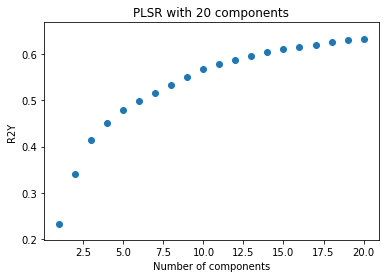

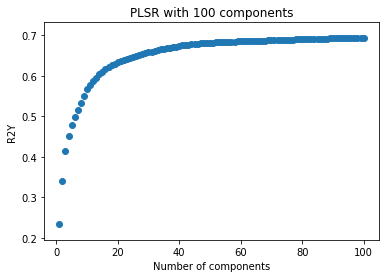

In [2]:
# Implement PLSR
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score

X = data[:, 0:277]
Y = data[:, 278]
Xnorm = pre.scale(X)
Ynorm = pre.scale(Y)


# Try with 20 components, determine R2 scores, and plot percent variance
r_arr = []
for i in range(1,21):
    pls_i = PLSRegression(n_components = i)
    pls_i.fit(Xnorm, Ynorm)
    Y_predi = pls_i.predict(Xnorm)
    r_arr.append(r2_score(Ynorm , Y_predi))
    
index = np.arange(1,21)
plt.scatter(index,r_arr);
plt.xlabel('Number of components');
plt.ylabel('R2Y');
plt.title('PLSR with 20 components');

# Try with 100 components, determine R2 scores, and plot percent variance
r_arr2 = []
for i in range(1,101):
    pls_i = PLSRegression(n_components = i)
    pls_i.fit(Xnorm, Ynorm)
    Y_predi = pls_i.predict(Xnorm)
    r_arr2.append(r2_score(Ynorm , Y_predi))

index2 = np.arange(1,101)
plt.figure();
plt.scatter(index2, r_arr2); 
plt.xlabel('Number of components');
plt.ylabel('R2Y');
plt.title('PLSR with 100 components');

In [3]:
# Perform leave-one-out cross validation with 100 components
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()

Y_obs = []
Y_pred = []
pls_loo = PLSRegression(n_components = 100)

for train_index, test_index in loo.split(X, Y):    
    pls_loo.fit_transform(X[train_index], Y[train_index])
    pls_loo.transform(X[test_index])
    
    ypred = pls_loo.predict(X[test_index])    
    yobs = Y[test_index]
    
    Y_obs.append(ypred[0,0])
    Y_pred.append(yobs[0]) 
    
r2_loo = r2_score(Y_obs, Y_pred)
print('R2 value: ', r2_loo)  

R2 value:  -0.01712539449533046


In [4]:
#attempting PLS-DA, only trying to distinguish between arrhythmia and no arr


#normalize X data according to how Yi says it should be
X_normal = pre.scale(X)

#make Y matrix of 0s and 1s - 0 = no arr, 1 = some type of arr
Y_binary = []
for i in range(len(Y)):
    if (Y[i] == 1): Y_binary.append(0)
    else: Y_binary.append(1)

#do PLSR
plsda = PLSRegression(n_components = 3)
pc_space = plsda.fit_transform(X_normal, Y_binary)[0]
Y_plsda = plsda.predict(X_normal)

#change predictions from PLS into binary values, and compare to Y_binary
for i in range(len(Y_plsda)):
    if (Y_plsda[i] > 0.5):
        Y_plsda[i] = 1
    else:
        Y_plsda[i] = 0

correct = 0
for i in range(len(Y_binary)):
    if (Y_binary[i] == Y_plsda[i]):
        correct += 1
print ("Percent correctly identified: (no crossvalidation): ", correct / len(Y_binary))


Percent correctly identified: (no crossvalidation):  0.8429203539823009


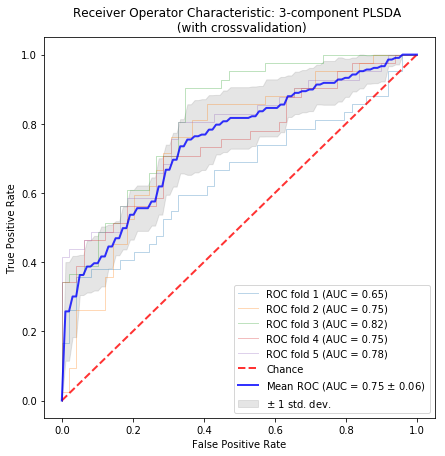

In [6]:
# trying to make an ROC curve with the crossvalidation results
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

Y_binary = np.array(Y_binary)

plt.figure(figsize = (7,7))

tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)

cv = StratifiedKFold(n_splits = 5)
i = 1
for train,test in cv.split(X_normal, Y_binary):
    plsda.fit(X_normal[train], Y_binary[train])
    Y_plsda = plsda.predict(X[test])
    fpr, tpr, thresholds = roc_curve(Y_binary[test], Y_plsda)
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    plt.legend()
    i += 1
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operator Characteristic: 3-component PLSDA \n (with crossvalidation)')

plt.legend();

Text(0.5, 1.0, 'Crossvalidated AUC for PLSDA Classifier')

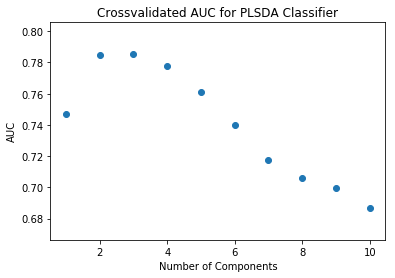

In [7]:
#Now getting average AUC for varied number of components

final_aucs = []
components = []
for numComponents in range(1,11):
    plsda = PLSRegression(n_components = numComponents)
    components.append(numComponents)
    tprs = []
    aucs = []
    for train,test in cv.split(X_normal, Y_binary):
        plsda.fit(X_normal[train], Y_binary[train])
        Y_plsda = plsda.predict(X[test])
        fpr, tpr, thresholds = roc_curve(Y_binary[test], Y_plsda)
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    final_aucs.append(mean_auc)

plt.scatter(components, final_aucs)
plt.xlabel("Number of Components")
plt.ylabel("AUC")
plt.title("Crossvalidated AUC for PLSDA Classifier")

In [59]:
from sklearn.svm import SVC

svc_linear = SVC(kernel='linear', C=1E6, gamma='auto')
svc_poly = SVC(kernel='poly', C=1E6, gamma='auto')
svc_RBF = SVC(kernel='rbf', C=1E6, gamma='auto')

Ypred_linear, Ypred_poly, Ypred_RBF = [np.zeros_like(Y) for i in range(3)]
cv_SVM = StratifiedKFold(n_splits = 5)

for train,test in cv_SVM.split(X_normal, Y):
    svc_linear.fit(X_normal[train], Y[train])
    svc_poly.fit(X_normal[train], Y[train])
    svc_RBF.fit(X_normal[train], Y[train])
    Ypred_linear[test] = svc_linear.predict(X_normal[test])
    Ypred_poly[test] = svc_poly.predict(X_normal[test])
    Ypred_RBF[test] = svc_RBF.predict(X_normal[test])


C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


In [62]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
       
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize = (10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

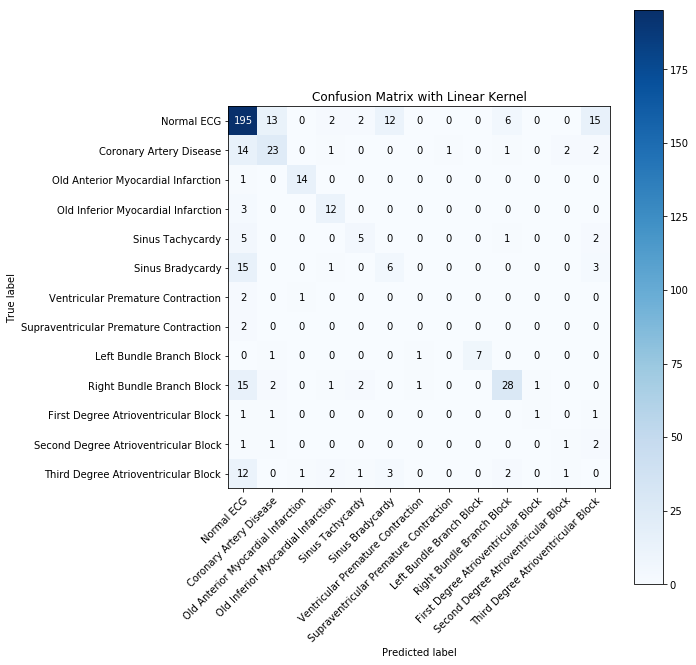

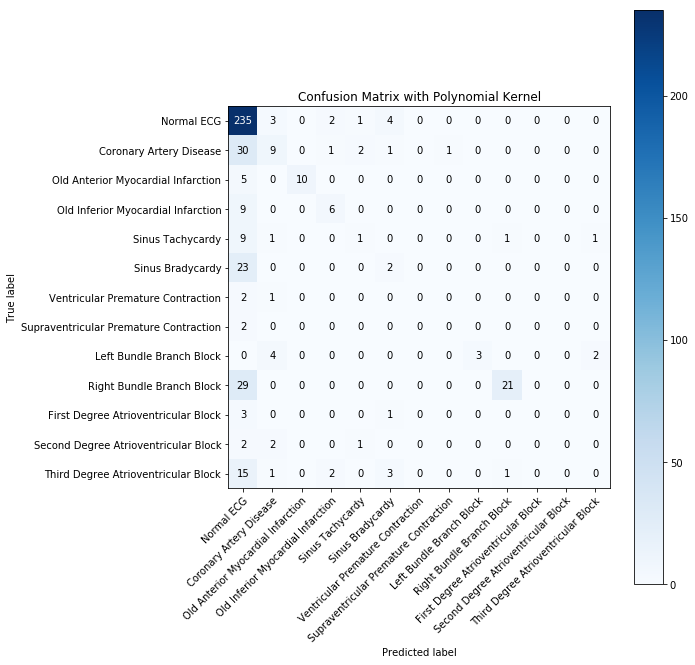

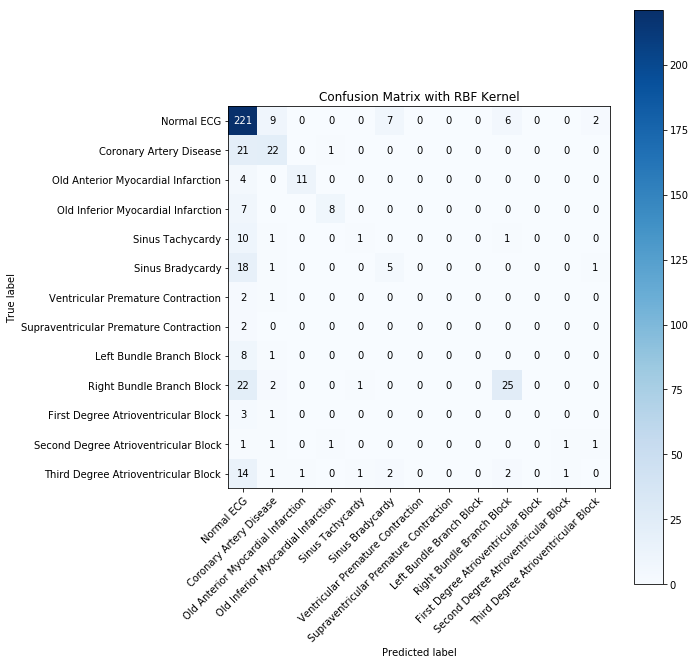

In [63]:
class_names = ["Normal ECG","Coronary Artery Disease","Old Anterior Myocardial Infarction","Old Inferior Myocardial Infarction",
               "Sinus Tachycardy","Sinus Bradycardy","Ventricular Premature Contraction","Supraventricular Premature Contraction",
               "Left Bundle Branch Block","Right Bundle Branch Block","First Degree Atrioventricular Block",
               "Second Degree Atrioventricular Block","Third Degree Atrioventricular Block","Left Ventricular Hypertrophy",
               "Atrial Fibrillation or Flutter","All other Arrhythmias"]

plot_confusion_matrix(Y.astype(int), Ypred_linear.astype(int), classes=class_names, title='Confusion Matrix with Linear Kernel');
plot_confusion_matrix(Y.astype(int), Ypred_poly.astype(int), classes=class_names, title='Confusion Matrix with Polynomial Kernel');
plot_confusion_matrix(Y.astype(int), Ypred_RBF.astype(int), classes=class_names, title='Confusion Matrix with RBF Kernel');